# American Sign Language (ASL) Image Recognition

## Introduction

## Loading in dataset

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile  
from sklearn.datasets import load_files
from keras.utils import np_utils
from keras.preprocessing import image                  
from tqdm import tqdm

# For compiling model
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

# For transfer learning
import scipy
import keras.applications.vgg16 as vgg16
import keras.applications.vgg19 as vgg19
import keras.applications.resnet50 as resnet50

# For confusion matrix calculation/visualization
import tensorflow as tf
import seaborn as sn
import pandas as pd

models_dir = 'saved_models'
data_dir = 'data'
bottleneck_feat_dir = 'bottleneck_features'

Using TensorFlow backend.


### Dividing data into training, validation, and testing sets

Now that preprocessing the images is completed (see `data_preprocessing.ipynb` notebook), the full dataset will be split into training, validation, and testing sets. The testing set will be all the images from one subject to mirror the "Spelling It Out" paper's method so the benchmark model can be compared. The rest of the images will be randomly split; 80% of images for training, 20% of the images for validation.

In [2]:
def load_dataset(path, n_categories=24):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    # Hot encode categories to matrix
    image_targets = np_utils.to_categorical(np.array(data['target']), n_categories)
    return image_files, image_targets

def move_data_by_category(container_dir, regex_file_format='.*png'):
    '''Move data into a directory based on category'''
    # Still check if files are images
    file_list = [x for x in os.listdir(container_dir) if re.search(regex_file_format, x)]
    # Get numerical string (note that 1 digits are represented w/ 2 digits) 
    letters = {x.split('_')[0] for x in file_list}
    
    for letter in letters:
        # Only images that match letter
        images_with_letter = [filename for filename in file_list if filename.split('_')[0] == letter]
        # Add images to sub directory
        new_categ_path = os.path.join(container_dir, letter)
        if not os.path.exists(new_categ_path):
            os.makedirs(new_categ_path)
#         print('Created {new_categ_path} dir with {len(images_with_letter)} items')
        for img_filename in images_with_letter:
            path = os.path.join(container_dir, img_filename)
            new_path = os.path.join(new_categ_path, img_filename)            
            os.rename(path, new_path)
    # TODO: Check if any files were skipped (improperly named?)
        

def get_testing_data(data_dir, subject_num='4'):
    '''Get all data/images pertaining to one subject'''
    # Only search in directory for images with that subject
    file_list = [x for x in os.listdir(data_dir) if re.search('\d+_{}_\d*\.png'.format(subject_num), x)]
    
    # Make a new testing data directory if doesn't exist
    testing_dir = os.path.join(data_dir, 'test')
    if not os.path.exists(testing_dir):
        os.makedirs(testing_dir)
        
    # Move images of particular subject into testing directory
    for image_filename in file_list:
        # file is **_n_****.png where n is an integer representing a subject
        _, subject, _ = image_filename.split('_')
        # Move file into testing directory
        path = os.path.join(data_dir, image_filename)
        new_path = os.path.join(testing_dir, image_filename)
        os.rename(path, new_path)
        
    # Move each image file's numerical str representing letters found in testing into own category directory
    move_data_by_category(testing_dir)
    
    return load_dataset(testing_dir)


def get_training_validation_data(data_dir, ratio=0.8):
    '''Randomly split data into training and validation sets'''
    # Only search in directory for images
    file_list = [x for x in os.listdir(data_dir) if re.search('.*png', x)]
    
    # Make a new training & validation data directory if doesn't exist
    train_dir = os.path.join(data_dir, 'train')
    valid_dir = os.path.join(data_dir, 'valid')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(valid_dir):
        os.makedirs(valid_dir)
        
    # Randomly split file list into training and vaidation sets
    np.random.shuffle(file_list)
    split_int = int(ratio * len(file_list))
    train_list = file_list[:split_int]
    valid_list = file_list[split_int:]
    
    # Move images of particular subject into testing directory
    for filenames, new_dir in [(train_list, train_dir), (valid_list, valid_dir)]:
        for image_filename in filenames:
            # Move file into testing directory
            path = os.path.join(data_dir, image_filename)
            new_path = os.path.join(new_dir, image_filename)
            os.rename(path, new_path)

        # Move each image file's numerical str representing letters found in testing into own category directory
        move_data_by_category(new_dir)
    
    return (load_dataset(train_dir), load_dataset(valid_dir))

In [3]:
# Manually set if the data is RGB
is_rgb = True

test_data, test_targets = get_testing_data(data_dir)
train, valid = get_training_validation_data(data_dir)
# Separated data and its targets
train_data, train_targets = train
valid_data, valid_targets = valid

### Display some of the images

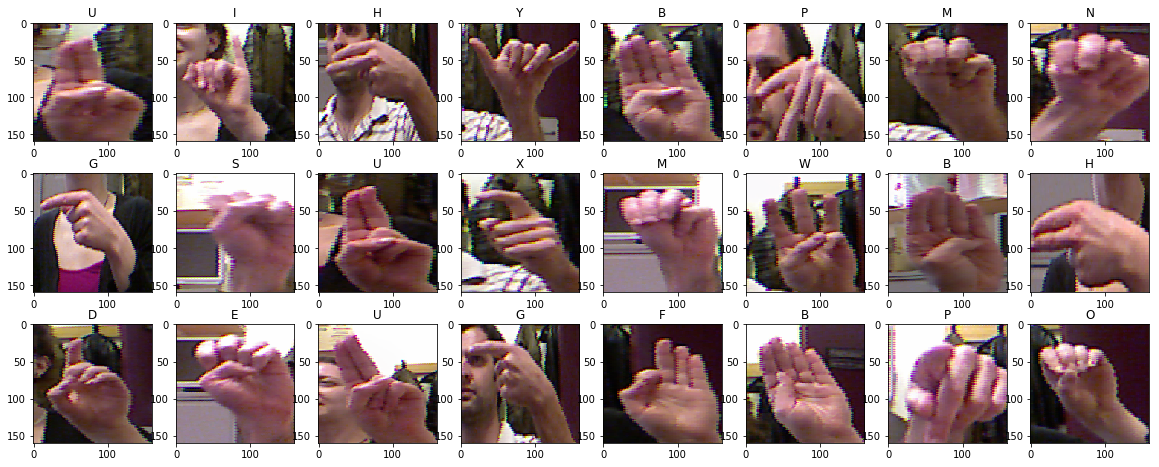

In [27]:
np.random.seed(8675309)
%matplotlib inline

# Display image previews below
plt.figure(figsize=(20,55))
columns = 8
n = 1

# Randomly choose images to display (with label)
for image_path in np.random.choice(train_data, 24, replace=False):
    img = Image.open(image_path)
    plt.subplot(20, columns, n)
    n+=1
    plt.imshow(img)
    letter = image_path.split('/')[-1][:2]
    letter = chr(int(letter)+65)
    plt.title(letter)

### Preparing the model

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
valid_tensors = paths_to_tensor(valid_data).astype('float32')
test_tensors = paths_to_tensor(test_data).astype('float32')

In [ ]:
# Prepare training data separately since this is usually large
train_tensors = paths_to_tensor(train_data).astype('float32')

## Basic CNN model from scratch

### Building basic model

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
#Convo 224, 224, 1
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 1)))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(GlobalAveragePooling2D())
#Dense; 24 for each handshape 
model.add(Dense(24, activation='softmax'))


model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training basic model

In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 16

# Create a saved models directory
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath=f'{models_dir}/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Evaluating basic model

In [ ]:
handshape_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(handshape_predictions)==np.argmax(test_targets, axis=1))/len(handshape_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

## Transfer Learning with VGG16

### Preparing the model

In [ ]:
# Define image size to use for given model
n_pixels = 80
# Define a model name for records
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

In [ ]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

In [ ]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

### Extract Bottleneck Features for Training Set

In [ ]:
# Name & path of bottleneck features
feat_train_name = 'vgg16_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load vgg16 model + remove final classification layers
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    vgg16_input_train = vgg16.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(vgg16_input_train)
    features = np.squeeze(features)
    np.savez(feat_train_path, features=features)

print('bottleneck features saved (train)')

### Extract Bottleneck Features for Validation Set

In [ ]:
# Name & path of bottleneck features
feat_valid_name = 'vgg16_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    vgg16_input_valid = vgg16.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(vgg16_input_valid)
    features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_path, features_test=features_valid)
print('bottleneck features saved (valid)')

### Extract Bottleneck Features for Test Set

In [ ]:
# Name & path of bottleneck features
feat_test_name = 'vgg16_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    vgg16_input_test = vgg16.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(vgg16_input_test)
    features_test = np.squeeze(features_test)
    np.savez(feat_test_path, features_test=features_test)
print('bottleneck features saved (test)')

### Building model

In [ ]:
features.shape
type(features)
features_ = features

In [ ]:
# 3 CNN Layers
model = Sequential()

model.add(Conv2D(filters=256, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=1))

model.add(Conv2D(filters=32, kernel_size=1))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
epochs = 50
batchsize = 500
model_weights_path = '{}/vgg16_{}.best_batch{}_epoch{}.hdf5'.format(models_dir,model_name,batchsize,epochs)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

### Evaluating the model

In [ ]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

## Transfer Learning with VGG19

### Preparing the model

In [ ]:
# Define image size to use for given model
n_pixels = 160
# Define a model name for recorcs
model_name = 'model_{}px'.format(n_pixels)

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

In [ ]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

In [ ]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

### Extract Bottleneck Features for Training Set

In [ ]:
# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load vgg19 model + remove final classification layers
model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists('vgg19_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('vgg19_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    vgg19_input_train = vgg19.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(vgg19_input_train)
    features = np.squeeze(features)
    np.savez('vgg19_features_train', features=features)

print('bottleneck features saved (train)')

### Extract Bottleneck Features for Validation Set

In [ ]:
# Obtain bottleneck features (valid)
if os.path.exists('vgg19_features_valid.npz'):
    print('bottleneck features detected (valid)')
    features_valid = np.load('vgg19_features_valid.npz')['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    vgg19_input_valid = vgg19.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(vgg19_input_valid)
    features_valid = np.squeeze(features_valid)
    np.savez('vgg19_features_valid', features_test=features_valid)
print('bottleneck features saved (valid)')

### Extract Bottleneck Features for Test Set

In [ ]:
# Obtain bottleneck features (test)
if os.path.exists('vgg19_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('vgg19_features_test.npz')['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    vgg19_input_test = vgg19.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(vgg19_input_test)
    features_test = np.squeeze(features_test)
    np.savez('vgg19_features_test', features_test=features_test)
print('bottleneck features saved (test)')

### Building model

In [ ]:
features.shape

In [ ]:
# Shallow NN
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=256, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



In [ ]:
epochs = 256
batchsize = 512
model_weights_path = f'{models_dir}/vgg19_new_{model_name}.best_batch{batchsize}_epoch{epochs}.hdf5'

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

### Evaluating the model

In [ ]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

## Transfer Learning with ResNet50

### Preparing the model

In [4]:
# Define image size to use for given model
n_pixels = 197
# Define a model name for records
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [5]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

  1%|          | 69/10599 [00:00<00:15, 686.63it/s]

Preparing to create valid tensors


100%|██████████| 10599/10599 [00:16<00:00, 658.26it/s]


valid tensors prepared


In [13]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

  0%|          | 58/12782 [00:00<00:22, 577.28it/s]

Preparing to create test tensors


100%|██████████| 12782/12782 [00:21<00:00, 594.40it/s]


test tensors prepared


In [12]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

Preparing to create train tensors
train tensors prepared


### Extract Bottleneck Features for Training Set

In [7]:
# Name & path of bottleneck features
feat_train_name = 'resnet50_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load resnet50 model + remove final classification layers
model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    resnet50_input_train = resnet50.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(resnet50_input_train)
#     features = np.squeeze(features)
    np.savez(feat_train_path, features=features)

print('bottleneck features saved (train)')

data loaded
model loaded
bottleneck features file not detected (train)
calculating now ...
train data preprocessed
bottleneck features saved (train)


### Extract Bottleneck Features for Validation Set

In [9]:
# Name & path of bottleneck features
feat_valid_name = 'resnet50_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    resnet50_input_valid = resnet50.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(resnet50_input_valid)
#     features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_path, features_test=features_valid)
print('bottleneck features saved (valid)')

bottleneck features file not detected (valid)
calculating now ...
bottleneck features saved (valid)


### Extract Bottleneck Features for Test Set

In [14]:
# Name & path of bottleneck features
feat_test_name = 'resnet50_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    resnet50_input_test = resnet50.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(resnet50_input_test)
#     features_test = np.squeeze(features_test)
    np.savez(feat_test_path, features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features file not detected (test)
calculating now ...
bottleneck features saved (test)


### Building model

In [44]:
features.shape

(42393, 1, 1, 2048)

In [45]:
# 3 CNN Layers
model = Sequential()

model.add(Conv2D(filters=512, kernel_size=1, input_shape=features.shape[1:]))
model.add(Dropout(0.4))

model.add(Conv2D(filters=256, kernel_size=1))

model.add(Conv2D(filters=128, kernel_size=1))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 1, 512)         1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 256)         131328    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 128)         32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1, 128)         0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [54]:
epochs = 512
batchsize = 350
model_details = 'resnet50_{}_batch{}_epoch{}'.format(model_name,batchsize,epochs)
model_weights_path = '{}/{}.hdf5'.format(models_dir,model_details)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

Train on 42393 samples, validate on 10599 samples
Epoch 1/512
Epoch 00000: val_loss improved from inf to 0.16344, saving model to saved_models/resnet50_rgbModel_197px_batch350_epoch512.hdf5
1s - loss: 0.1794 - acc: 0.9638 - val_loss: 0.1634 - val_acc: 0.9634
Epoch 2/512
Epoch 00001: val_loss did not improve
1s - loss: 0.1667 - acc: 0.9644 - val_loss: 0.5654 - val_acc: 0.8938
Epoch 3/512
Epoch 00002: val_loss improved from 0.16344 to 0.14132, saving model to saved_models/resnet50_rgbModel_197px_batch350_epoch512.hdf5
1s - loss: 0.1776 - acc: 0.9620 - val_loss: 0.1413 - val_acc: 0.9668
Epoch 4/512
Epoch 00003: val_loss did not improve
1s - loss: 0.1555 - acc: 0.9641 - val_loss: 0.2338 - val_acc: 0.9538
Epoch 5/512
Epoch 00004: val_loss did not improve
1s - loss: 0.1630 - acc: 0.9640 - val_loss: 0.2777 - val_acc: 0.9409
Epoch 6/512
Epoch 00005: val_loss improved from 0.14132 to 0.10290, saving model to saved_models/resnet50_rgbModel_197px_batch350_epoch512.hdf5
1s - loss: 0.1451 - acc: 0.

Epoch 00063: val_loss did not improve
1s - loss: 0.0985 - acc: 0.9767 - val_loss: 0.2443 - val_acc: 0.9540
Epoch 65/512
Epoch 00064: val_loss did not improve
1s - loss: 0.0881 - acc: 0.9781 - val_loss: 0.3830 - val_acc: 0.9380
Epoch 66/512
Epoch 00065: val_loss did not improve
1s - loss: 0.0928 - acc: 0.9774 - val_loss: 0.3095 - val_acc: 0.9437
Epoch 67/512
Epoch 00066: val_loss did not improve
1s - loss: 0.0954 - acc: 0.9777 - val_loss: 0.3226 - val_acc: 0.9422
Epoch 68/512
Epoch 00067: val_loss did not improve
1s - loss: 0.0823 - acc: 0.9794 - val_loss: 0.5202 - val_acc: 0.9233
Epoch 69/512
Epoch 00068: val_loss did not improve
1s - loss: 0.1047 - acc: 0.9764 - val_loss: 0.4506 - val_acc: 0.9301
Epoch 70/512
Epoch 00069: val_loss did not improve
1s - loss: 0.0948 - acc: 0.9783 - val_loss: 0.0836 - val_acc: 0.9825
Epoch 71/512
Epoch 00070: val_loss did not improve
1s - loss: 0.0875 - acc: 0.9788 - val_loss: 0.2334 - val_acc: 0.9583
Epoch 72/512
Epoch 00071: val_loss did not improve
1s

Epoch 00131: val_loss did not improve
1s - loss: 0.0799 - acc: 0.9831 - val_loss: 0.0896 - val_acc: 0.9834
Epoch 133/512
Epoch 00132: val_loss did not improve
1s - loss: 0.0807 - acc: 0.9832 - val_loss: 0.2359 - val_acc: 0.9631
Epoch 134/512
Epoch 00133: val_loss did not improve
1s - loss: 0.0786 - acc: 0.9832 - val_loss: 0.1531 - val_acc: 0.9743
Epoch 135/512
Epoch 00134: val_loss did not improve
1s - loss: 0.0818 - acc: 0.9831 - val_loss: 0.1002 - val_acc: 0.9819
Epoch 136/512
Epoch 00135: val_loss did not improve
1s - loss: 0.0808 - acc: 0.9837 - val_loss: 0.0953 - val_acc: 0.9839
Epoch 137/512
Epoch 00136: val_loss did not improve
1s - loss: 0.0768 - acc: 0.9841 - val_loss: 0.2559 - val_acc: 0.9622
Epoch 138/512
Epoch 00137: val_loss did not improve
1s - loss: 0.0768 - acc: 0.9846 - val_loss: 0.4983 - val_acc: 0.9366
Epoch 139/512
Epoch 00138: val_loss did not improve
1s - loss: 0.0843 - acc: 0.9828 - val_loss: 0.0995 - val_acc: 0.9819
Epoch 140/512
Epoch 00139: val_loss did not im

Epoch 00199: val_loss did not improve
1s - loss: 0.0932 - acc: 0.9849 - val_loss: 0.1484 - val_acc: 0.9817
Epoch 201/512
Epoch 00200: val_loss did not improve
1s - loss: 0.0833 - acc: 0.9858 - val_loss: 0.1478 - val_acc: 0.9820
Epoch 202/512
Epoch 00201: val_loss did not improve
1s - loss: 0.0878 - acc: 0.9855 - val_loss: 0.4150 - val_acc: 0.9513
Epoch 203/512
Epoch 00202: val_loss did not improve
1s - loss: 0.0853 - acc: 0.9857 - val_loss: 0.3135 - val_acc: 0.9634
Epoch 204/512
Epoch 00203: val_loss did not improve
1s - loss: 0.0881 - acc: 0.9862 - val_loss: 0.3799 - val_acc: 0.9588
Epoch 205/512
Epoch 00204: val_loss did not improve
1s - loss: 0.0811 - acc: 0.9868 - val_loss: 0.1486 - val_acc: 0.9810
Epoch 206/512
Epoch 00205: val_loss did not improve
1s - loss: 0.0814 - acc: 0.9867 - val_loss: 0.3208 - val_acc: 0.9645
Epoch 207/512
Epoch 00206: val_loss did not improve
1s - loss: 0.0898 - acc: 0.9857 - val_loss: 0.4068 - val_acc: 0.9579
Epoch 208/512
Epoch 00207: val_loss did not im

Epoch 00267: val_loss did not improve
1s - loss: 0.1428 - acc: 0.9853 - val_loss: 0.2184 - val_acc: 0.9802
Epoch 269/512
Epoch 00268: val_loss did not improve
1s - loss: 0.1316 - acc: 0.9869 - val_loss: 0.2152 - val_acc: 0.9816
Epoch 270/512
Epoch 00269: val_loss did not improve
1s - loss: 0.1400 - acc: 0.9857 - val_loss: 0.6671 - val_acc: 0.9459
Epoch 271/512
Epoch 00270: val_loss did not improve
1s - loss: 0.1428 - acc: 0.9859 - val_loss: 0.2047 - val_acc: 0.9814
Epoch 272/512
Epoch 00271: val_loss did not improve
1s - loss: 0.1421 - acc: 0.9859 - val_loss: 0.2186 - val_acc: 0.9803
Epoch 273/512
Epoch 00272: val_loss did not improve
1s - loss: 0.1368 - acc: 0.9857 - val_loss: 0.1693 - val_acc: 0.9849
Epoch 274/512
Epoch 00273: val_loss did not improve
1s - loss: 0.1467 - acc: 0.9848 - val_loss: 0.1781 - val_acc: 0.9835
Epoch 275/512
Epoch 00274: val_loss did not improve
1s - loss: 0.1438 - acc: 0.9858 - val_loss: 0.2274 - val_acc: 0.9809
Epoch 276/512
Epoch 00275: val_loss did not im

Epoch 00335: val_loss did not improve
1s - loss: 0.2509 - acc: 0.9813 - val_loss: 0.3764 - val_acc: 0.9736
Epoch 337/512
Epoch 00336: val_loss did not improve
1s - loss: 0.2827 - acc: 0.9788 - val_loss: 0.6752 - val_acc: 0.9535
Epoch 338/512
Epoch 00337: val_loss did not improve
1s - loss: 0.2527 - acc: 0.9814 - val_loss: 0.2542 - val_acc: 0.9822
Epoch 339/512
Epoch 00338: val_loss did not improve
1s - loss: 0.2499 - acc: 0.9817 - val_loss: 0.4861 - val_acc: 0.9665
Epoch 340/512
Epoch 00339: val_loss did not improve
1s - loss: 0.2546 - acc: 0.9808 - val_loss: 0.2880 - val_acc: 0.9799
Epoch 341/512
Epoch 00340: val_loss did not improve
1s - loss: 0.2693 - acc: 0.9803 - val_loss: 0.3110 - val_acc: 0.9780
Epoch 342/512
Epoch 00341: val_loss did not improve
1s - loss: 0.2807 - acc: 0.9799 - val_loss: 0.3519 - val_acc: 0.9752
Epoch 343/512
Epoch 00342: val_loss did not improve
1s - loss: 0.2579 - acc: 0.9812 - val_loss: 0.2541 - val_acc: 0.9823
Epoch 344/512
Epoch 00343: val_loss did not im

Epoch 00403: val_loss did not improve
1s - loss: 0.4427 - acc: 0.9707 - val_loss: 0.3354 - val_acc: 0.9781
Epoch 405/512
Epoch 00404: val_loss did not improve
1s - loss: 0.4668 - acc: 0.9693 - val_loss: 0.8722 - val_acc: 0.9441
Epoch 406/512
Epoch 00405: val_loss did not improve
1s - loss: 0.4579 - acc: 0.9695 - val_loss: 0.3919 - val_acc: 0.9741
Epoch 407/512
Epoch 00406: val_loss did not improve
1s - loss: 0.3945 - acc: 0.9737 - val_loss: 0.3425 - val_acc: 0.9775
Epoch 408/512
Epoch 00407: val_loss did not improve
1s - loss: 0.4472 - acc: 0.9705 - val_loss: 0.5254 - val_acc: 0.9662
Epoch 409/512
Epoch 00408: val_loss did not improve
1s - loss: 0.4321 - acc: 0.9714 - val_loss: 0.3729 - val_acc: 0.9754
Epoch 410/512
Epoch 00409: val_loss did not improve
1s - loss: 0.5003 - acc: 0.9671 - val_loss: 0.5397 - val_acc: 0.9647
Epoch 411/512
Epoch 00410: val_loss did not improve
1s - loss: 0.4339 - acc: 0.9712 - val_loss: 0.3877 - val_acc: 0.9750
Epoch 412/512
Epoch 00411: val_loss did not im

Epoch 00471: val_loss did not improve
1s - loss: 0.5134 - acc: 0.9667 - val_loss: 0.4111 - val_acc: 0.9738
Epoch 473/512
Epoch 00472: val_loss did not improve
1s - loss: 0.6092 - acc: 0.9607 - val_loss: 0.4332 - val_acc: 0.9720
Epoch 474/512
Epoch 00473: val_loss did not improve
1s - loss: 0.5576 - acc: 0.9638 - val_loss: 0.4009 - val_acc: 0.9742
Epoch 475/512
Epoch 00474: val_loss did not improve
1s - loss: 0.5412 - acc: 0.9649 - val_loss: 0.4667 - val_acc: 0.9700
Epoch 476/512
Epoch 00475: val_loss did not improve
1s - loss: 0.5931 - acc: 0.9620 - val_loss: 0.4480 - val_acc: 0.9711
Epoch 477/512
Epoch 00476: val_loss did not improve
1s - loss: 0.5760 - acc: 0.9632 - val_loss: 0.3714 - val_acc: 0.9764
Epoch 478/512
Epoch 00477: val_loss did not improve
1s - loss: 0.5729 - acc: 0.9631 - val_loss: 0.4459 - val_acc: 0.9713
Epoch 479/512
Epoch 00478: val_loss did not improve
1s - loss: 0.5549 - acc: 0.9641 - val_loss: 0.5296 - val_acc: 0.9663
Epoch 480/512
Epoch 00479: val_loss did not im

### Evaluating the model

In [55]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 70.3333%


## Confusion Matrix of Test Data

After performing tests, a confusion matrix can be used to evaluate the model and it's accuracy for each ASL handshape/letter. Below we use the weight's from the last model defined and used above to generate our confusion matrix.

In [56]:
# Load the weights of latest model run
model.load_weights(model_weights_path)

test_predictions = model.predict_classes(features_test)

12128/12782 [===========================>..] - ETA: 0s

In [57]:
sess = tf.Session()
# Change one-hot encoding to just an integer representing letter
un_hot_encode_targets = np.argmax(test_targets, axis=1)

confusion_arr = sess.run(tf.confusion_matrix(un_hot_encode_targets, test_predictions, 24))
# Get percents to compare with research paper benchmark
confusion_arr_percents = confusion_arr/sum(confusion_arr)

In [58]:
# Note no 'J' & 'Z' were used
letters = "ABCDEFGHIKLMNOPQRSTUVWXY"

# Print out counts to see distribution of the number of letters tested against
for elem in ['{}: {}'.format(letter,count) for letter,count in zip(letters,sum(confusion_arr))]:
    print(elem)

A: 720
B: 550
C: 577
D: 557
E: 718
F: 510
G: 785
H: 161
I: 658
K: 599
L: 455
M: 514
N: 687
O: 387
P: 453
Q: 330
R: 455
S: 734
T: 237
U: 604
V: 795
W: 527
X: 350
Y: 419


In [59]:
# Save confusion matrix/array as CSVs for reference
np.savetxt('confusion_matrices/confusionMatrix_{}_counts.csv'.format(model_details),confusion_arr)
np.savetxt('confusion_matrices/confusionMatrix_{}_percent.csv'.format(model_details),confusion_arr_percents)

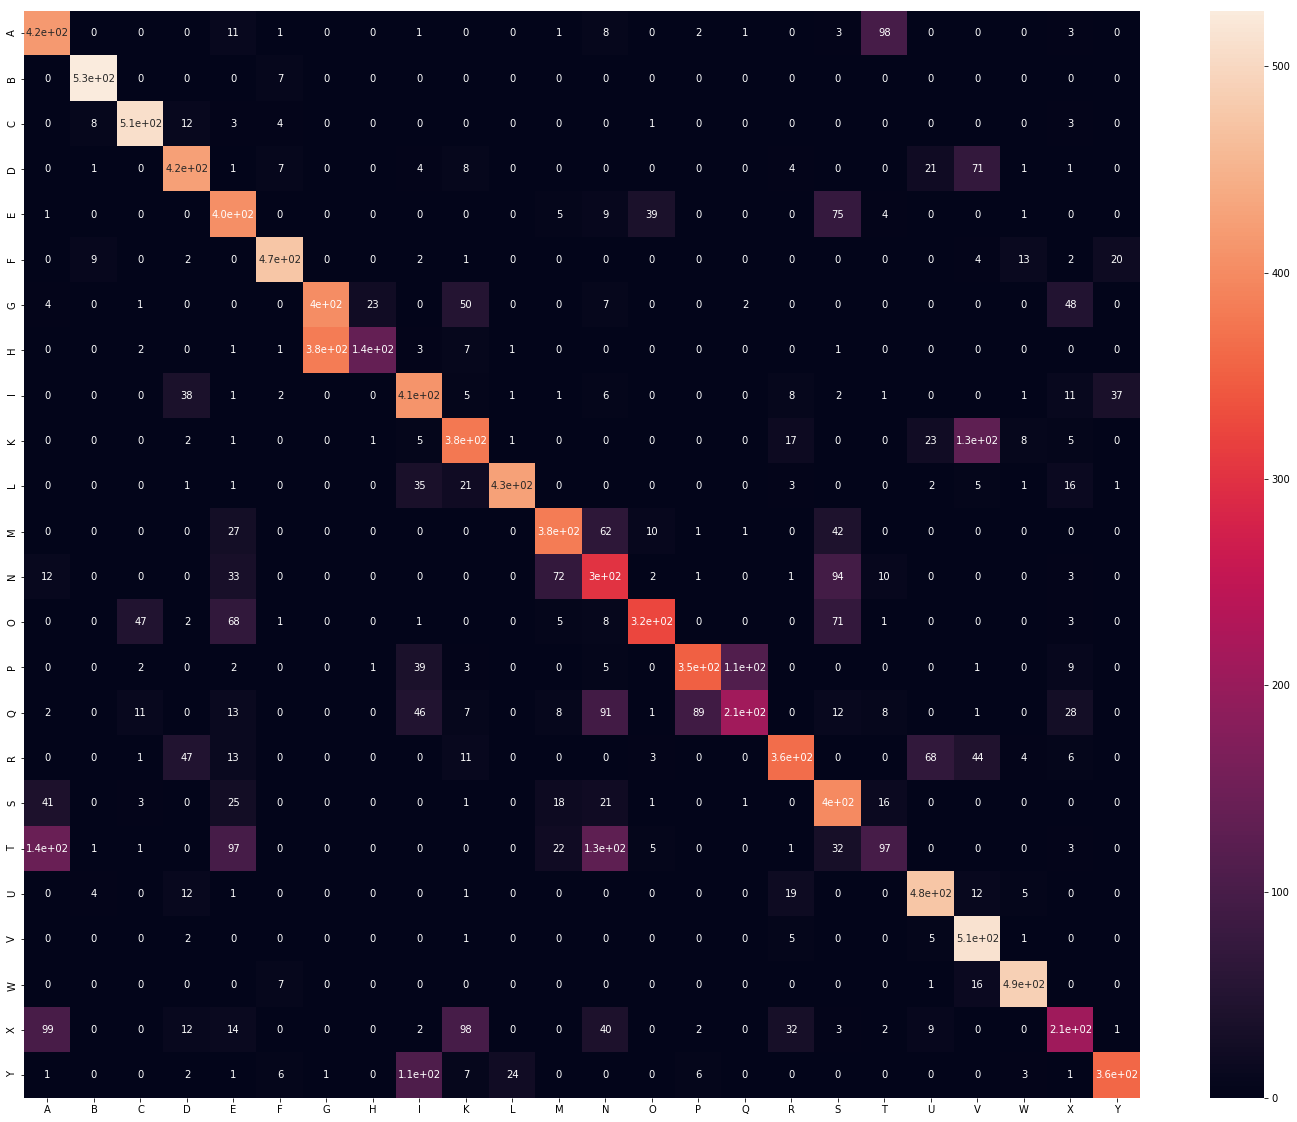

In [60]:
df_cm = pd.DataFrame(confusion_arr, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (25,20))
sn.heatmap(df_cm, annot=True)

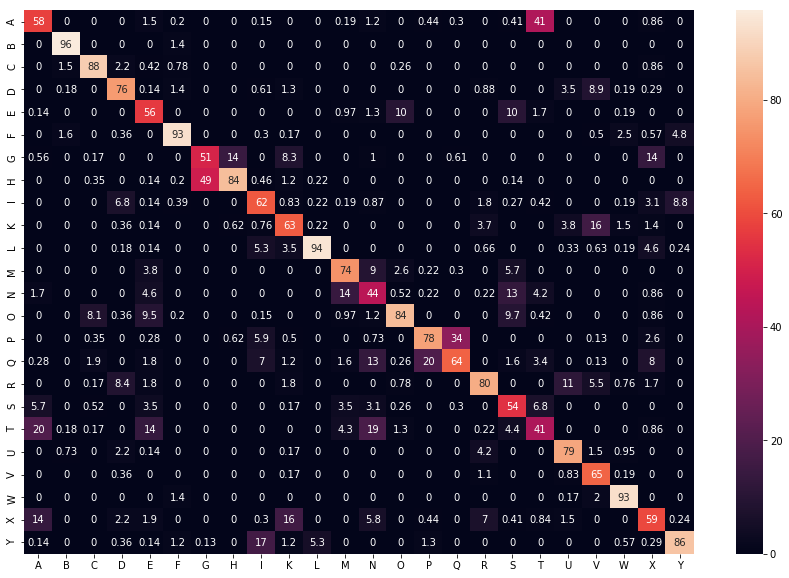

In [61]:
# Percentages for confusion matrix
# Multiplied by 100 to make it easier to read values
df_cm = pd.DataFrame(confusion_arr_percents*100, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)